In [12]:
import numpy as np
from SALib.sample import fast_sampler
from SALib.analyze import sobol
from SALib.analyze import fast
import matplotlib.pyplot as plt
from SALib import ProblemSpec
from SALib.sample import saltelli

##########################
#http0.1://salib.readthedocs.io/en/latest/basics_with_interface.html
##########################
import sys
import os
sys.path.insert(0, os.path.abspath('../model'))
import Pacejka52 as pa52
import Pacejka52_Sv_Sh_0 as pa52_0
import Pacejka52_params_comp as pa52pa

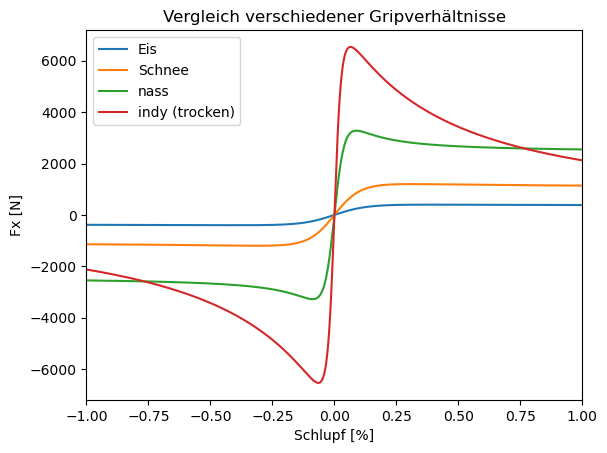

In [13]:
#
#Vergleich verschiedener Reifen, Schne, Eis, Normal pkw, rennreifen
#
# https://de.mathworks.com/help/sdl/ref/tireroadinteractionmagicformula.html
#
# longitutinal

params_ice = [4 ,2 ,0.1 ,1]
params_snow = [5, 2, 0.3, 1]
params_wet = [12, 2.3,0.82, 1]
params_dry = [10,1.9,1,0.97]
params_indy =  [19.7526835 ,  1.99999146 , 1.63455163 , 0.75471735]
params_pkw = [13.99267598 , 1.58731849,  1.44239588 , 0.64342384]

i = 1000
Sx = np.linspace(-1,1,i)
Sy = np.linspace(-0.3,0.3,i)
Fz = 4000
IA = 0
Fz0 = 3114

Fx_ice = pa52.Pacejka5_long_pa(Sx,Fz,*params_ice)
Fx_snow = pa52.Pacejka5_long_pa(Sx,Fz,*params_snow) 
Fx_wet = pa52.Pacejka5_long_pa(Sx,Fz,*params_wet) 
Fx_dry = pa52.Pacejka5_long_pa(Sx,Fz,*params_dry) 
Fx_indy = pa52.Pacejka5_long_pa(Sx,Fz,*params_indy) 
Fx_pkw = pa52.Pacejka5_long_pa(Sx,Fz,*params_pkw)
Fx_indy_52 = pa52pa.Pacejka52_long(Fz,Sx,IA,Fz0,'INDY')[0]
Fx_pkw_52 = pa52pa.Pacejka52_long(Fz,Sx,IA,Fz0,'PKW')[0]

plt.figure(1)
plt.plot(Sx,Fx_ice, label =  'Eis')
plt.plot(Sx,Fx_snow, label =  'Schnee')
plt.plot(Sx,Fx_wet, label =  'nass')
#plt.plot(Sx,Fx_dry, label =  'trocken')
plt.plot(Sx,Fx_indy, label =  'indy (trocken)')
#plt.plot(Sx,Fx_pkw, label = 'pkw')
#plt.plot(Sx,Fx_indy_52, label = 'indy_52')
#plt.plot(Sx,Fx_pkw_52, label = 'pkw_52')
plt.xlim(-1,1)
plt.xlabel('Schlupf [%]')
plt.ylabel('Fx [N]')
plt.title('Vergleich verschiedener Gripverhältnisse')
plt.legend()

In [16]:
######
# gloabel SA mit Sobol  ice
######

#same SA for Pacejka5 lateral

import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec
SL = np.linspace(0,1,200)

#function

F_ref = pa52.Pacejka5_long_pa(SL,Fz,*params_ice)
F_max = np.max(F_ref)
F_ref_plt = np.zeros(len(F_ref))

for i in range(0, len(F_ref)):
    F_ref_plt[i] = F_ref[i] / F_max
s=0.1
# [4 ,2 ,0.1 ,1]
sp = ProblemSpec({
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    'bounds': [[4 * (1-s),4 * (1+s)], [2* (1-s), 2* (1+s)], [0.1* (1-s), 0.1* (1+s)], [1* (1-s), 1* (1+s)]],
})


# Create wrapper (runs each a, b combination separately)
def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = pa52.Pacejka5_long_pa(SL, Fz,B,C,D,E)

    return y


itera = 12

(
sp.sample_sobol(2**itera) #16000 iterationen
.evaluate(wrapped_function)
.analyze_sobol()
)

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])

STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])
y = sp.results

#Plot: Sensitivity Index für jeden Wert von SL
# Set up figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 1)
fig.suptitle('First order Sobol index')
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
# Populate figure subplots
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.plot(SL, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(sp["names"][i]),
            color='black')
    ax.set_xlabel("Schlupf [%]")
    ax.set_ylabel("Sobol index")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.legend(loc='upper right')

#alle zusammen plotten
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,8))
fig.suptitle('Parameter = Eis, Fz = 4000')

S1s_B  = np.array(S1s[:,0])
S1s_B[0] = S1s_B[1]
S1s_C  = np.array(S1s[:,1])
S1s_C[0] = S1s_C[1]
S1s_D  = np.array(S1s[:,2])
S1s_D[0] = S1s_D[1]
S1s_E  = np.array(S1s[:,3])
S1s_E[0] = S1s_E[1]

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

ax1.fill_between(SL, S1s_B, 0, alpha=0.5, label='B')
ax1.fill_between(SL, S1s_B, S1s_C_plt, where=(S1s_C_plt > S1s_B), alpha=0.5, label='C')
ax1.fill_between(SL, S1s_C_plt, S1s_D_plt, where=(S1s_D_plt > S1s_C_plt), alpha=0.5, label='D')
ax1.fill_between(SL, S1s_D_plt, S1s_E_plt, where=(S1s_E_plt > S1s_D_plt), alpha=0.5, label='E')
#ax1.plot(SL, F_ref_plt, 'r--', label='Fx_ref')
ax1.set_xlabel('Schlupf [%]')
ax1.set_ylabel('Sobol Index first-order')
ax1.set_title('Pacejka 5 longitudinal')
ax1.set_xlim(0,0.6)
ax1.set_ylim(0,1)

color = 'tab:red'
ax3 = ax1.twinx()
ax3.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax3.set_ylim(0,410)
ax3.set_ylabel('Fx [N]', color = color)
ax3.tick_params(axis='y', labelcolor='red')

ln1, lab1 = ax1.get_legend_handles_labels()
ln3, lab3 = ax3.get_legend_handles_labels()
lns = ln1 + ln3
labs = lab1 + lab3
ax1.legend(lns, labs, loc='lower right')

STs_B  = np.array(STs[:,0])
STs_B[0] = STs_B[1]
STs_C  = np.array(STs[:,1])
STs_C[0] = STs_C[1]
STs_D  = np.array(STs[:,2])
STs_D[0] = STs_D[1]
STs_E  = np.array(STs[:,3])
STs_E[0] = STs_E[1]

STs_C_plt = np.array([x+y for x,y in zip(STs_B,STs_C)])
STs_D_plt = np.array([x+y for x,y in zip(STs_C_plt,STs_D)])
STs_E_plt = np.array([x+y for x,y in zip(STs_D_plt,STs_E)])

ax2.fill_between(SL, STs_B, 0, alpha=0.5, label='B')
ax2.fill_between(SL, STs_B, STs_C_plt, where=(STs_C_plt > STs_B), alpha=0.5, label='C')
ax2.fill_between(SL, STs_C_plt, STs_D_plt, where=(STs_D_plt > STs_C_plt), alpha=0.5, label='D')
ax2.fill_between(SL, STs_D_plt, STs_E_plt, where=(STs_E_plt > STs_D_plt), alpha=0.5, label='E')
#x2.plot(SL, F_ref_plt, 'r--', label='Fx_ref')
ax2.set_xlabel('Schlupf [%]')
ax2.set_ylabel('Sobol total Index')
ax2.set_title('Pacejka 5 longitudinal')
ax2.legend(loc='upper right')
ax1.set_xlim(0,0.6)
ax2.set_ylim(0,1)

ax4 = ax2.twinx()
ax4.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax4.set_ylim(0,410)
ax4.set_ylabel('Fx [N]', color = color)
ax4.tick_params(axis='y', labelcolor='red')

ln2, lab2 = ax1.get_legend_handles_labels()
ln4, lab4 = ax3.get_legend_handles_labels()
lns = ln2 + ln4
labs = lab2 + lab4
ax2.legend(lns, labs, loc='lower right')






c:\Users\bener\anaconda3\lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean()) / Y.std()


KeyboardInterrupt: 

C:\Users\bener\AppData\Local\Temp\ipykernel_22988\2616150296.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax3.plot(SL,F_ref, 'r--', label='F_ref',color = color)
C:\Users\bener\AppData\Local\Temp\ipykernel_22988\2616150296.py:141: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax4.plot(SL,F_ref, 'r--', label='F_ref',color = color)


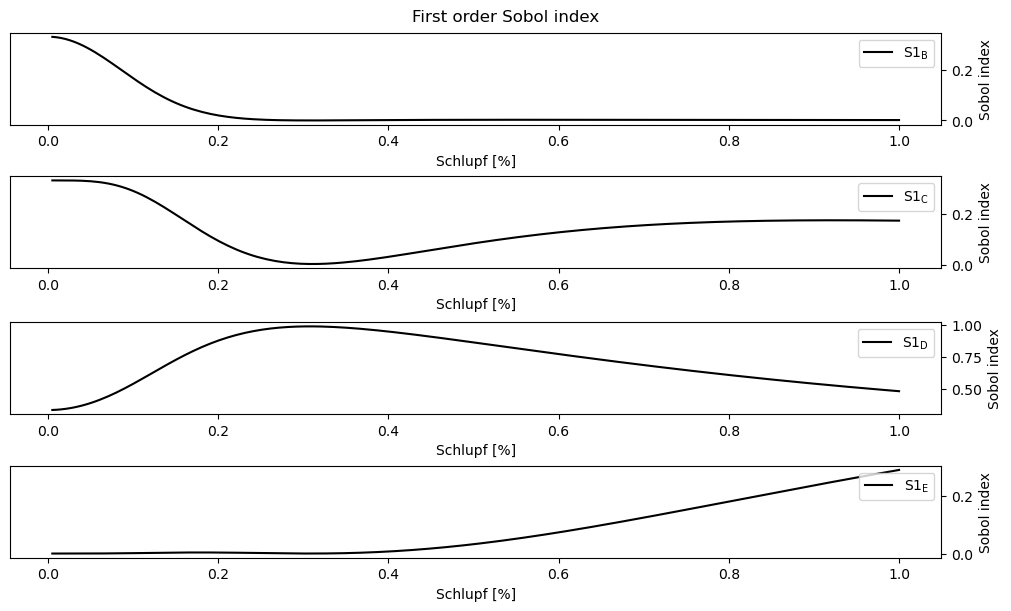

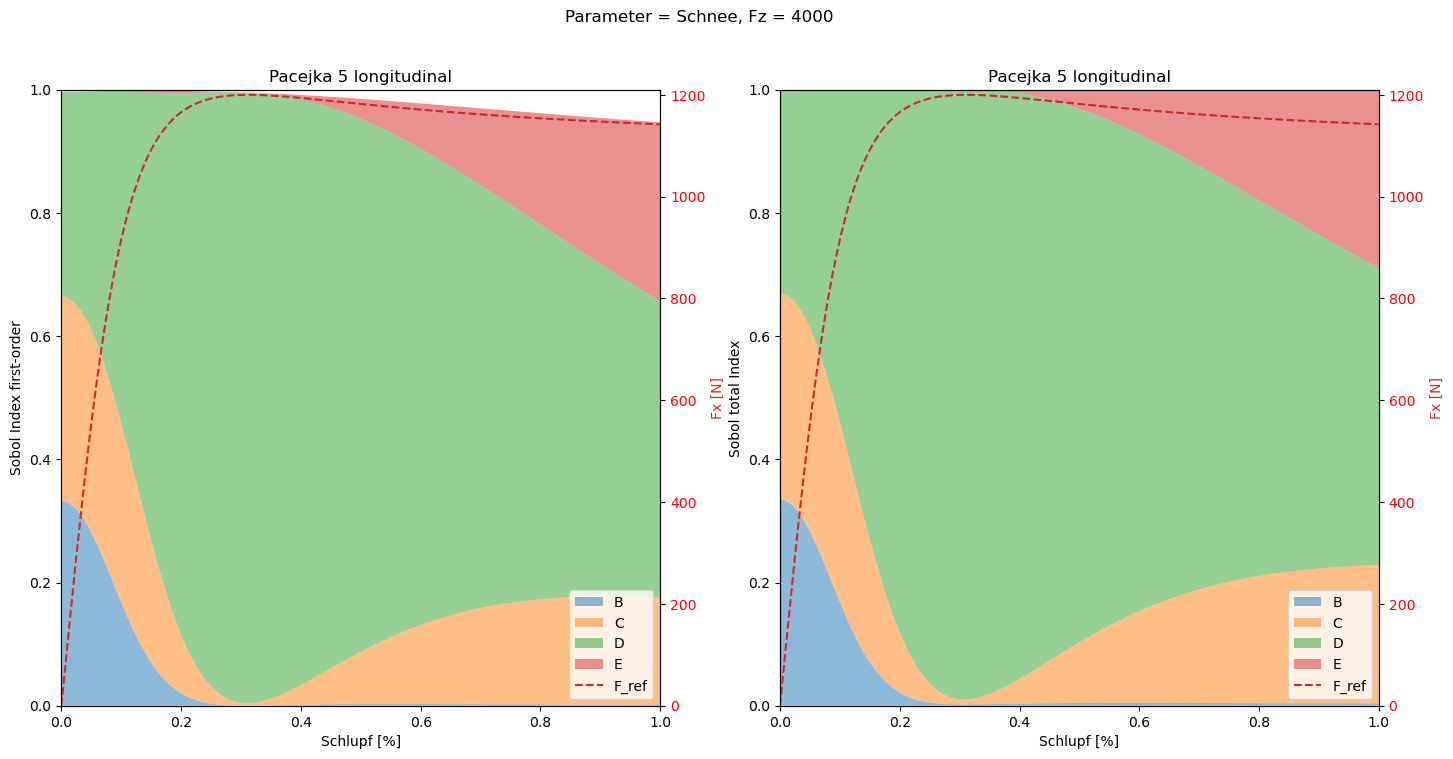

In [ ]:
######
# gloabel SA mit Sobol  Schnee
######

#same SA for Pacejka5 lateral

import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec
SL = np.linspace(0,1,300)

#function

F_ref = Pacejka5_long_pa(SL,*params_snow)
F_max = np.max(F_ref)
F_ref_plt = np.zeros(len(F_ref))

for i in range(0, len(F_ref)):
    F_ref_plt[i] = F_ref[i] / F_max
s=0.1

sp = ProblemSpec({
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    'bounds': [[5 * (1-s),5 * (1+s)], [2* (1-s), 2* (1+s)], [0.3* (1-s), 0.3* (1+s)], [1* (1-s), 1* (1+s)]],
})


# Create wrapper (runs each a, b combination separately)
def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = pa52.Pacejka5_long_pa(SL, Fz,B,C,D,E)

    return y


itera = 15

(
sp.sample_sobol(2**itera) #16000 iterationen
.evaluate(wrapped_function)
.analyze_sobol()
)

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])

STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])
y = sp.results

#Plot: Sensitivity Index für jeden Wert von SL
# Set up figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 1)
fig.suptitle('First order Sobol index')
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
# Populate figure subplots
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.plot(SL, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(sp["names"][i]),
            color='black')
    ax.set_xlabel("Schlupf [%]")
    ax.set_ylabel("Sobol index")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.legend(loc='upper right')

#alle zusammen plotten
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,8))
fig.suptitle('Parameter = Schnee, Fz = 4000')

S1s_B  = np.array(S1s[:,0])
S1s_B[0] = S1s_B[1]
S1s_C  = np.array(S1s[:,1])
S1s_C[0] = S1s_C[1]
S1s_D  = np.array(S1s[:,2])
S1s_D[0] = S1s_D[1]
S1s_E  = np.array(S1s[:,3])
S1s_E[0] = S1s_E[1]

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

ax1.fill_between(SL, S1s_B, 0, alpha=0.5, label='B')
ax1.fill_between(SL, S1s_B, S1s_C_plt, where=(S1s_C_plt > S1s_B), alpha=0.5, label='C')
ax1.fill_between(SL, S1s_C_plt, S1s_D_plt, where=(S1s_D_plt > S1s_C_plt), alpha=0.5, label='D')
ax1.fill_between(SL, S1s_D_plt, S1s_E_plt, where=(S1s_E_plt > S1s_D_plt), alpha=0.5, label='E')
ax1.set_xlabel('Schlupf [%]')
ax1.set_ylabel('Sobol Index first-order')
ax1.set_title('Pacejka 5 longitudinal')
ax1.set_xlim(0,0.6)
ax1.set_ylim(0,1)

color = 'tab:red'
ax3 = ax1.twinx()
ax3.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax3.set_ylim(0,1210)
ax3.set_ylabel('Fx [N]', color = color)
ax3.tick_params(axis='y', labelcolor='red')

ln1, lab1 = ax1.get_legend_handles_labels()
ln3, lab3 = ax3.get_legend_handles_labels()
lns = ln1 + ln3
labs = lab1 + lab3
ax1.legend(lns, labs, loc='lower right')

STs_B  = np.array(STs[:,0])
STs_B[0] = STs_B[1]
STs_C  = np.array(STs[:,1])
STs_C[0] = STs_C[1]
STs_D  = np.array(STs[:,2])
STs_D[0] = STs_D[1]
STs_E  = np.array(STs[:,3])
STs_E[0] = STs_E[1]

STs_C_plt = np.array([x+y for x,y in zip(STs_B,STs_C)])
STs_D_plt = np.array([x+y for x,y in zip(STs_C_plt,STs_D)])
STs_E_plt = np.array([x+y for x,y in zip(STs_D_plt,STs_E)])

ax2.fill_between(SL, STs_B, 0, alpha=0.5, label='B')
ax2.fill_between(SL, STs_B, STs_C_plt, where=(STs_C_plt > STs_B), alpha=0.5, label='C')
ax2.fill_between(SL, STs_C_plt, STs_D_plt, where=(STs_D_plt > STs_C_plt), alpha=0.5, label='D')
ax2.fill_between(SL, STs_D_plt, STs_E_plt, where=(STs_E_plt > STs_D_plt), alpha=0.5, label='E')
#x2.plot(SL, F_ref_plt, 'r--', label='Fx_ref')
ax2.set_xlabel('Schlupf [%]')
ax2.set_ylabel('Sobol total Index')
ax2.set_title('Pacejka 5 longitudinal')
ax2.legend(loc='upper right')
ax1.set_xlim(0,0.6)
ax2.set_ylim(0,1)

ax4 = ax2.twinx()
ax4.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax4.set_ylim(0,1210)
ax4.set_ylabel('Fx [N]', color = color)
ax4.tick_params(axis='y', labelcolor='red')

ln2, lab2 = ax1.get_legend_handles_labels()
ln4, lab4 = ax3.get_legend_handles_labels()
lns = ln2 + ln4
labs = lab2 + lab4
ax2.legend(lns, labs, loc='lower right')

C:\Users\bener\AppData\Local\Temp\ipykernel_22988\3241343844.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax3.plot(SL,F_ref, 'r--', label='F_ref',color = color)
C:\Users\bener\AppData\Local\Temp\ipykernel_22988\3241343844.py:141: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax4.plot(SL,F_ref, 'r--', label='F_ref',color = color)


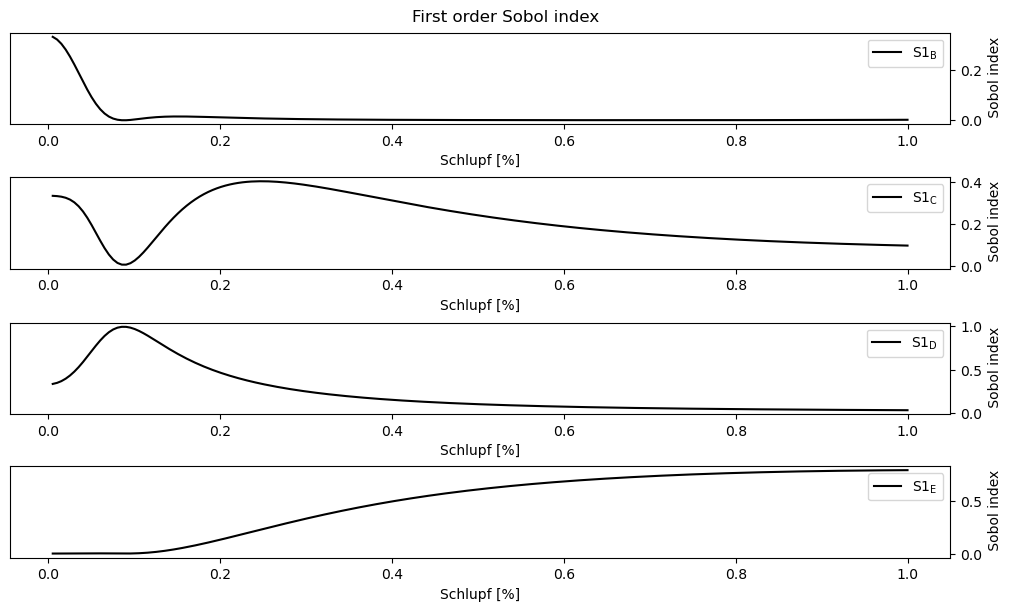

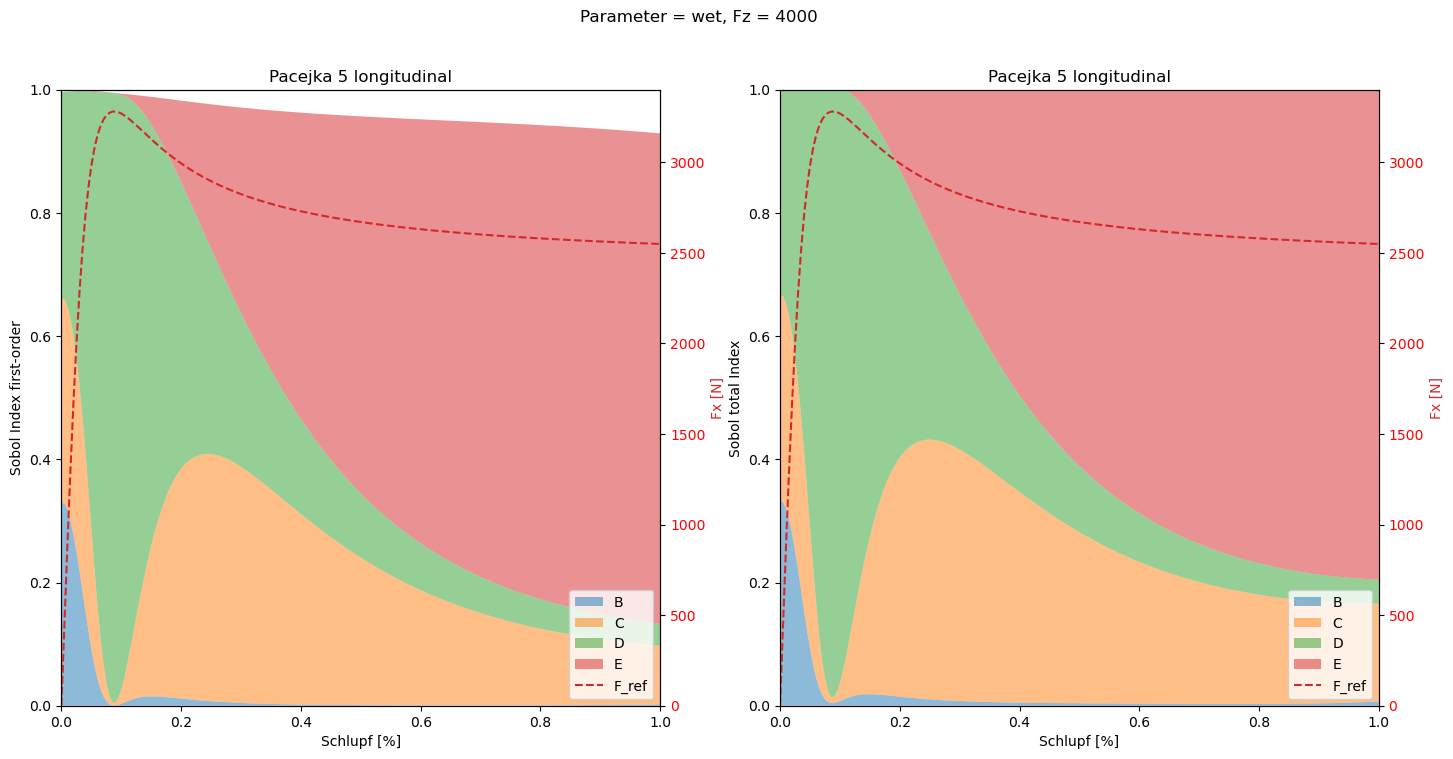

In [ ]:
######
# gloabel SA mit Sobol  wet
######

#same SA for Pacejka5 lateral

import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec
SL = np.linspace(0,1,300)

#function

F_ref = Pacejka5_long_pa(SL,*params_wet)
F_max = np.max(F_ref)
F_ref_plt = np.zeros(len(F_ref))

for i in range(0, len(F_ref)):
    F_ref_plt[i] = F_ref[i] / F_max
s=0.1

sp = ProblemSpec({
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    'bounds': [[12 * (1-s),12 * (1+s)], [2.3* (1-s), 2.3* (1+s)], [0.82* (1-s), 0.82* (1+s)], [1* (1-s), 1* (1+s)]],
})


# Create wrapper (runs each a, b combination separately)
def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = pa52.Pacejka5_long_pa(SL, Fz,B,C,D,E)

    return y


itera = 15

(
sp.sample_sobol(2**itera) #16000 iterationen
.evaluate(wrapped_function)
.analyze_sobol()
)

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])

STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])
y = sp.results

#Plot: Sensitivity Index für jeden Wert von SL
# Set up figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 1)
fig.suptitle('First order Sobol index')
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
# Populate figure subplots
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.plot(SL, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(sp["names"][i]),
            color='black')
    ax.set_xlabel("Schlupf [%]")
    ax.set_ylabel(" Sobol index")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.legend(loc='upper right')

#alle zusammen plotten
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,8))
fig.suptitle('Parameter = wet, Fz = 4000')

S1s_B  = np.array(S1s[:,0])
S1s_B[0] = S1s_B[1]
S1s_C  = np.array(S1s[:,1])
S1s_C[0] = S1s_C[1]
S1s_D  = np.array(S1s[:,2])
S1s_D[0] = S1s_D[1]
S1s_E  = np.array(S1s[:,3])
S1s_E[0] = S1s_E[1]

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

ax1.fill_between(SL, S1s_B, 0, alpha=0.5, label='B')
ax1.fill_between(SL, S1s_B, S1s_C_plt, where=(S1s_C_plt > S1s_B), alpha=0.5, label='C')
ax1.fill_between(SL, S1s_C_plt, S1s_D_plt, where=(S1s_D_plt > S1s_C_plt), alpha=0.5, label='D')
ax1.fill_between(SL, S1s_D_plt, S1s_E_plt, where=(S1s_E_plt > S1s_D_plt), alpha=0.5, label='E')
ax1.set_xlabel('Schlupf [%]')
ax1.set_ylabel('Sobol Index first-order')
ax1.set_title('Pacejka 5 longitudinal')
ax1.set_xlim(0,0.6)
ax1.set_ylim(0,1)

color = 'tab:red'
ax3 = ax1.twinx()
ax3.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax3.set_ylim(0,3400)
ax3.set_ylabel('Fx [N]', color = color)
ax3.tick_params(axis='y', labelcolor='red')

ln1, lab1 = ax1.get_legend_handles_labels()
ln3, lab3 = ax3.get_legend_handles_labels()
lns = ln1 + ln3
labs = lab1 + lab3
ax1.legend(lns, labs, loc='lower right')

STs_B  = np.array(STs[:,0])
STs_B[0] = STs_B[1]
STs_C  = np.array(STs[:,1])
STs_C[0] = STs_C[1]
STs_D  = np.array(STs[:,2])
STs_D[0] = STs_D[1]
STs_E  = np.array(STs[:,3])
STs_E[0] = STs_E[1]

STs_C_plt = np.array([x+y for x,y in zip(STs_B,STs_C)])
STs_D_plt = np.array([x+y for x,y in zip(STs_C_plt,STs_D)])
STs_E_plt = np.array([x+y for x,y in zip(STs_D_plt,STs_E)])

ax2.fill_between(SL, STs_B, 0, alpha=0.5, label='B')
ax2.fill_between(SL, STs_B, STs_C_plt, where=(STs_C_plt > STs_B), alpha=0.5, label='C')
ax2.fill_between(SL, STs_C_plt, STs_D_plt, where=(STs_D_plt > STs_C_plt), alpha=0.5, label='D')
ax2.fill_between(SL, STs_D_plt, STs_E_plt, where=(STs_E_plt > STs_D_plt), alpha=0.5, label='E')
#x2.plot(SL, F_ref_plt, 'r--', label='Fx_ref')
ax2.set_xlabel('Schlupf [%]')
ax2.set_ylabel('Sobol total Index')
ax2.set_title('Pacejka 5 longitudinal')
ax2.legend(loc='upper right')
ax1.set_xlim(0,0.6)
ax2.set_ylim(0,1)

ax4 = ax2.twinx()
ax4.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax4.set_ylim(0,3400)
ax4.set_ylabel('Fx [N]', color = color)
ax4.tick_params(axis='y', labelcolor='red')

ln2, lab2 = ax1.get_legend_handles_labels()
ln4, lab4 = ax3.get_legend_handles_labels()
lns = ln2 + ln4
labs = lab2 + lab4
ax2.legend(lns, labs, loc='lower right')

C:\Users\bener\AppData\Local\Temp\ipykernel_22988\2358821108.py:104: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax3.plot(SL,F_ref, 'r--', label='F_ref',color = color)
C:\Users\bener\AppData\Local\Temp\ipykernel_22988\2358821108.py:141: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax4.plot(SL,F_ref, 'r--', label='F_ref',color = color)


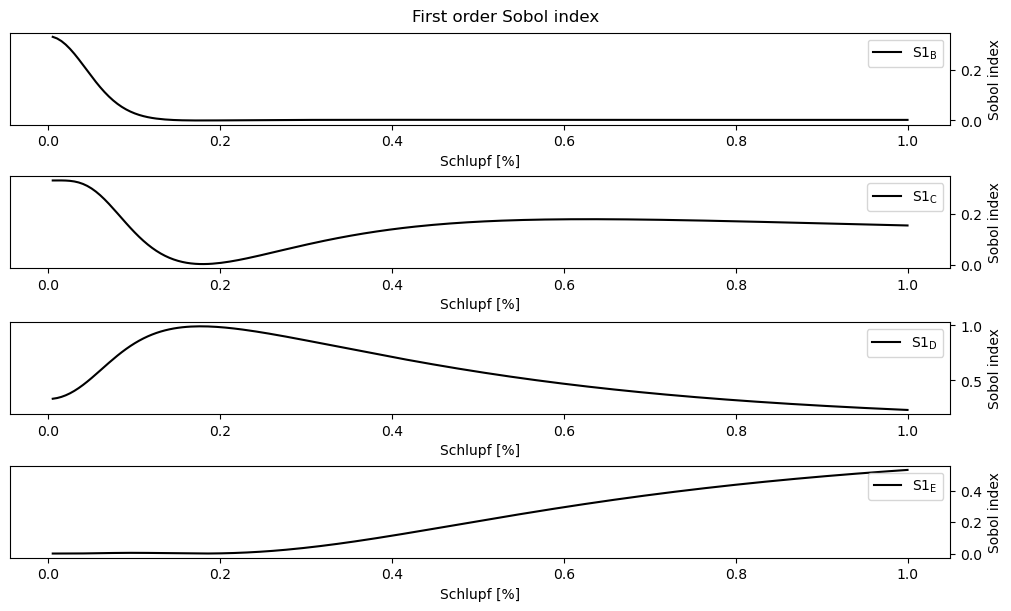

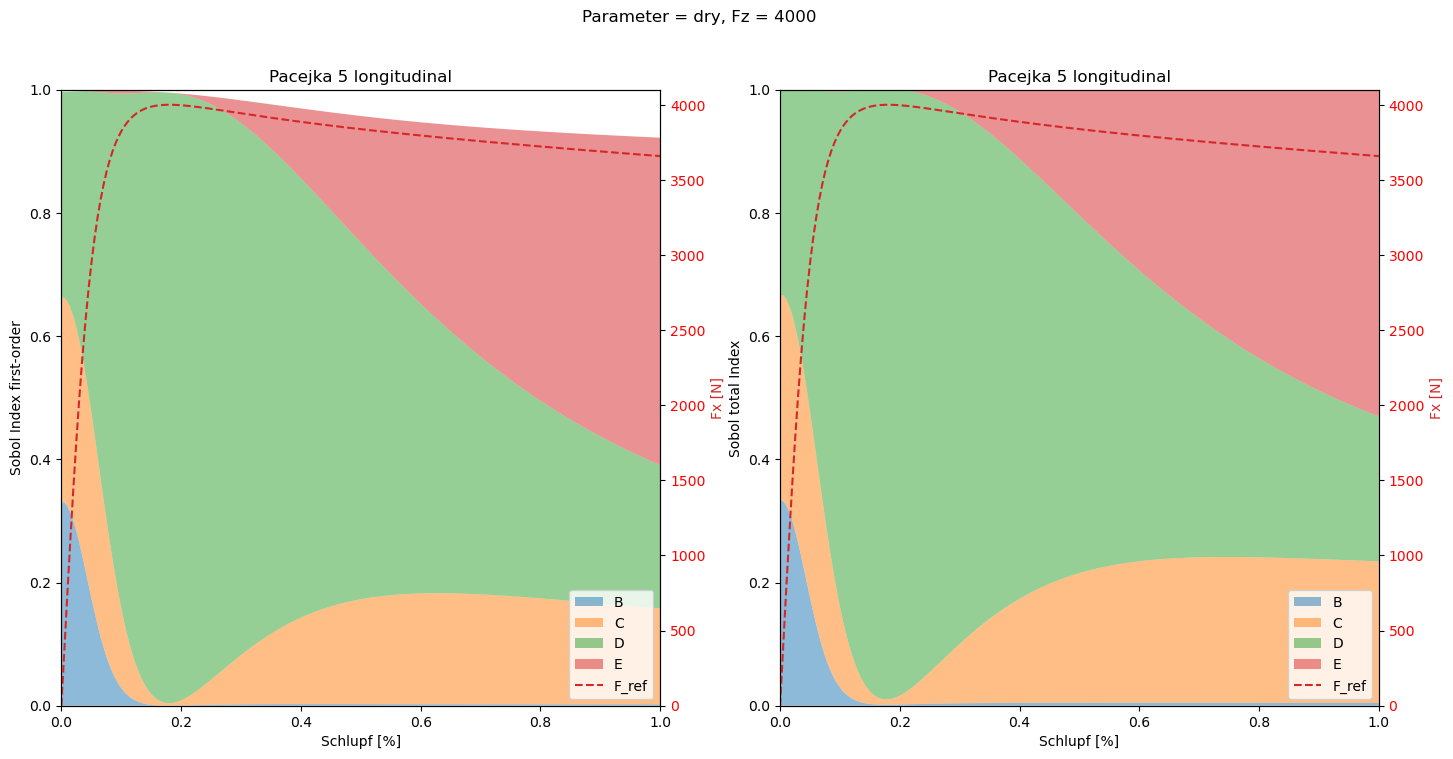

In [ ]:
######
# gloabel SA mit Sobol  dry
######

#same SA for Pacejka5 lateral

import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec
SL = np.linspace(0,1,300)

#function

F_ref = Pacejka5_long_pa(SL,*params_dry)
F_max = np.max(F_ref)
F_ref_plt = np.zeros(len(F_ref))

for i in range(0, len(F_ref)):
    F_ref_plt[i] = F_ref[i] / F_max
s=0.1

sp = ProblemSpec({
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    'bounds': [[10 * (1-s),10 * (1+s)], [1.9* (1-s), 1.9* (1+s)], [1* (1-s), 1* (1+s)], [0.97* (1-s), 0.97* (1+s)]],
})


# Create wrapper (runs each a, b combination separately)
def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = pa52.Pacejka5_long_pa(SL, Fz,B,C,D,E)

    return y


itera = 15

(
sp.sample_sobol(2**itera) #16000 iterationen
.evaluate(wrapped_function)
.analyze_sobol()
)

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])

STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])
y = sp.results

#Plot: Sensitivity Index für jeden Wert von SL
# Set up figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 1)
fig.suptitle('First order Sobol index')
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
# Populate figure subplots
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.plot(SL, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(sp["names"][i]),
            color='black')
    ax.set_xlabel("Schlupf [%]")
    ax.set_ylabel("Sobol index")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.legend(loc='upper right')

#alle zusammen plotten
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,8))
fig.suptitle('Parameter = dry, Fz = 4000')

S1s_B  = np.array(S1s[:,0])
S1s_B[0] = S1s_B[1]
S1s_C  = np.array(S1s[:,1])
S1s_C[0] = S1s_C[1]
S1s_D  = np.array(S1s[:,2])
S1s_D[0] = S1s_D[1]
S1s_E  = np.array(S1s[:,3])
S1s_E[0] = S1s_E[1]

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

ax1.fill_between(SL, S1s_B, 0, alpha=0.5, label='B')
ax1.fill_between(SL, S1s_B, S1s_C_plt, where=(S1s_C_plt > S1s_B), alpha=0.5, label='C')
ax1.fill_between(SL, S1s_C_plt, S1s_D_plt, where=(S1s_D_plt > S1s_C_plt), alpha=0.5, label='D')
ax1.fill_between(SL, S1s_D_plt, S1s_E_plt, where=(S1s_E_plt > S1s_D_plt), alpha=0.5, label='E')
ax1.set_xlabel('Schlupf [%]')
ax1.set_ylabel('Sobol Index first-order')
ax1.set_title('Pacejka 5 longitudinal')
ax1.set_xlim(0,0.6)
ax1.set_ylim(0,1)

color = 'tab:red'
ax3 = ax1.twinx()
ax3.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax3.set_ylim(0,4100)
ax3.set_ylabel('Fx [N]', color = color)
ax3.tick_params(axis='y', labelcolor='red')

ln1, lab1 = ax1.get_legend_handles_labels()
ln3, lab3 = ax3.get_legend_handles_labels()
lns = ln1 + ln3
labs = lab1 + lab3
ax1.legend(lns, labs, loc='lower right')

STs_B  = np.array(STs[:,0])
STs_B[0] = STs_B[1]
STs_C  = np.array(STs[:,1])
STs_C[0] = STs_C[1]
STs_D  = np.array(STs[:,2])
STs_D[0] = STs_D[1]
STs_E  = np.array(STs[:,3])
STs_E[0] = STs_E[1]

STs_C_plt = np.array([x+y for x,y in zip(STs_B,STs_C)])
STs_D_plt = np.array([x+y for x,y in zip(STs_C_plt,STs_D)])
STs_E_plt = np.array([x+y for x,y in zip(STs_D_plt,STs_E)])

ax2.fill_between(SL, STs_B, 0, alpha=0.5, label='B')
ax2.fill_between(SL, STs_B, STs_C_plt, where=(STs_C_plt > STs_B), alpha=0.5, label='C')
ax2.fill_between(SL, STs_C_plt, STs_D_plt, where=(STs_D_plt > STs_C_plt), alpha=0.5, label='D')
ax2.fill_between(SL, STs_D_plt, STs_E_plt, where=(STs_E_plt > STs_D_plt), alpha=0.5, label='E')
#x2.plot(SL, F_ref_plt, 'r--', label='Fx_ref')
ax2.set_xlabel('Schlupf [%]')
ax2.set_ylabel('Sobol total Index')
ax2.set_title('Pacejka 5 longitudinal')
ax2.legend(loc='upper right')
ax1.set_xlim(0,0.6)
ax2.set_ylim(0,1)

ax4 = ax2.twinx()
ax4.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax4.set_ylim(0,4100)
ax4.set_ylabel('Fx [N]', color = color)
ax4.tick_params(axis='y', labelcolor='red')

ln2, lab2 = ax1.get_legend_handles_labels()
ln4, lab4 = ax3.get_legend_handles_labels()
lns = ln2 + ln4
labs = lab2 + lab4
ax2.legend(lns, labs, loc='lower right')

In [9]:
# INDY

#[19.7526835 ,  1.99999146 , 1.63455163 , 0.75471735]
######
# gloabel SA mit Sobol  dry
######

#same SA for Pacejka5 lateral

import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec
SL = np.linspace(0,1,300)

#function

F_ref = Pacejka5_long_pa(SL,*params_indy)
F_max = np.max(F_ref)
F_ref_plt = np.zeros(len(F_ref))

for i in range(0, len(F_ref)):
    F_ref_plt[i] = F_ref[i] / F_max
s=0.1

sp = ProblemSpec({
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    'bounds': [[19.7526835 * (1-s),19.7526835 * (1+s)], [1.99999146* (1-s), 1.99999146* (1+s)], 
                [1.63455163* (1-s), 1.63455163* (1+s)], [0.75471735* (1-s), 0.75471735* (1+s)]],
})


# Create wrapper (runs each a, b combination separately)
def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = pa52.Pacejka5_long_pa(SL, Fz,B,C,D,E)

    return y


itera = 15

(
sp.sample_sobol(2**itera) #16000 iterationen
.evaluate(wrapped_function)
.analyze_sobol()
)

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])

STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])
y = sp.results

#Plot: Sensitivity Index für jeden Wert von SL
# Set up figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 1)
fig.suptitle('First order Sobol index')
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
# Populate figure subplots
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.plot(SL, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(sp["names"][i]),
            color='black')
    ax.set_xlabel("Schlupf [%]")
    ax.set_ylabel("Sobol index")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.legend(loc='upper right')

#alle zusammen plotten
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,8))
fig.suptitle('Parameter = indy, Fz = 4000')

S1s_B  = np.array(S1s[:,0])
S1s_B[0] = S1s_B[1]
S1s_C  = np.array(S1s[:,1])
S1s_C[0] = S1s_C[1]
S1s_D  = np.array(S1s[:,2])
S1s_D[0] = S1s_D[1]
S1s_E  = np.array(S1s[:,3])
S1s_E[0] = S1s_E[1]

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

ax1.fill_between(SL, S1s_B, 0, alpha=0.5, label='B')
ax1.fill_between(SL, S1s_B, S1s_C_plt, where=(S1s_C_plt > S1s_B), alpha=0.5, label='C')
ax1.fill_between(SL, S1s_C_plt, S1s_D_plt, where=(S1s_D_plt > S1s_C_plt), alpha=0.5, label='D')
ax1.fill_between(SL, S1s_D_plt, S1s_E_plt, where=(S1s_E_plt > S1s_D_plt), alpha=0.5, label='E')
ax1.set_xlabel('Schlupf [%]')
ax1.set_ylabel('Sobol Index first-order')
ax1.set_title('Pacejka 5 longitudinal')
ax1.set_xlim(0,0.6)
ax1.set_ylim(0,1)

color = 'tab:red'
ax3 = ax1.twinx()
ax3.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax3.set_ylim(0,7000)
ax3.set_ylabel('Fx [N]', color = color)
ax3.tick_params(axis='y', labelcolor='red')

ln1, lab1 = ax1.get_legend_handles_labels()
ln3, lab3 = ax3.get_legend_handles_labels()
lns = ln1 + ln3
labs = lab1 + lab3
ax1.legend(lns, labs, loc='lower right')

STs_B  = np.array(STs[:,0])
STs_B[0] = STs_B[1]
STs_C  = np.array(STs[:,1])
STs_C[0] = STs_C[1]
STs_D  = np.array(STs[:,2])
STs_D[0] = STs_D[1]
STs_E  = np.array(STs[:,3])
STs_E[0] = STs_E[1]

STs_C_plt = np.array([x+y for x,y in zip(STs_B,STs_C)])
STs_D_plt = np.array([x+y for x,y in zip(STs_C_plt,STs_D)])
STs_E_plt = np.array([x+y for x,y in zip(STs_D_plt,STs_E)])

ax2.fill_between(SL, STs_B, 0, alpha=0.5, label='B')
ax2.fill_between(SL, STs_B, STs_C_plt, where=(STs_C_plt > STs_B), alpha=0.5, label='C')
ax2.fill_between(SL, STs_C_plt, STs_D_plt, where=(STs_D_plt > STs_C_plt), alpha=0.5, label='D')
ax2.fill_between(SL, STs_D_plt, STs_E_plt, where=(STs_E_plt > STs_D_plt), alpha=0.5, label='E')
#x2.plot(SL, F_ref_plt, 'r--', label='Fx_ref')
ax2.set_xlabel('Schlupf [%]')
ax2.set_ylabel('Sobol total Index')
ax2.set_title('Pacejka 5 longitudinal')
ax2.legend(loc='upper right')
ax1.set_xlim(0,0.6)
ax2.set_ylim(0,1)

ax4 = ax2.twinx()
ax4.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax4.set_ylim(0,7000)
ax4.set_ylabel('Fx [N]', color = color)
ax4.tick_params(axis='y', labelcolor='red')

ln2, lab2 = ax1.get_legend_handles_labels()
ln4, lab4 = ax3.get_legend_handles_labels()
lns = ln2 + ln4
labs = lab2 + lab4
ax2.legend(lns, labs, loc='lower right')

NameError: name 'Pacejka5_long_pa' is not defined

C:\Users\bener\AppData\Local\Temp\ipykernel_56144\1209276590.py:108: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax3.plot(SL,F_ref, 'r--', label='F_ref',color = color)


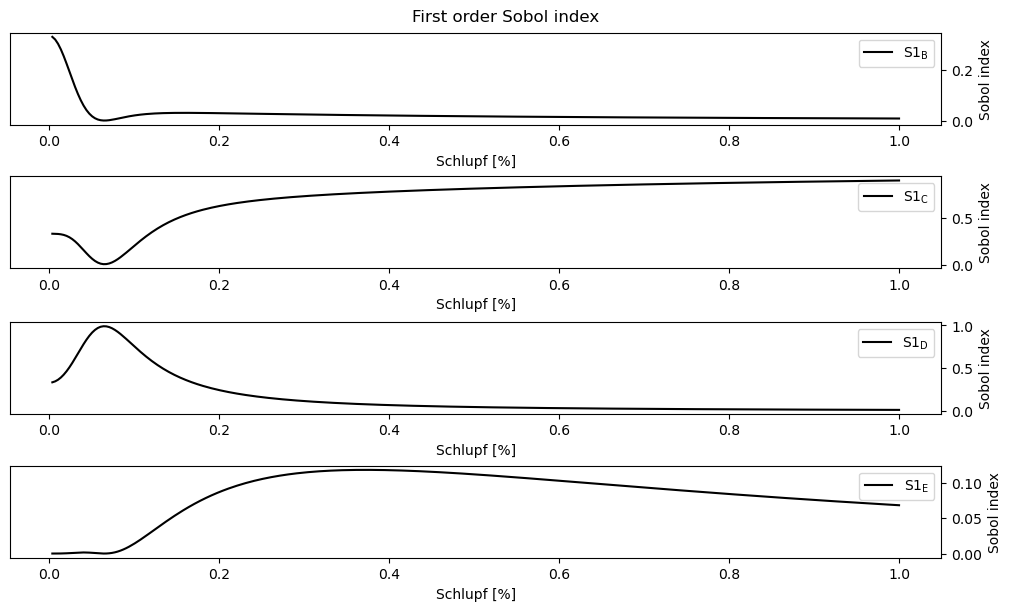

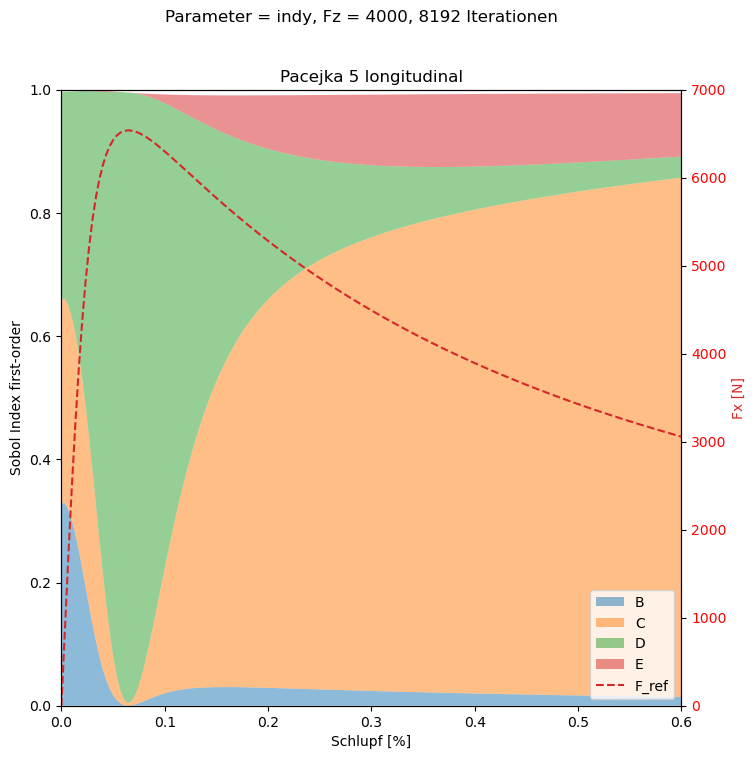

In [32]:
# INDY

#[19.7526835 ,  1.99999146 , 1.63455163 , 0.75471735]
######
# gloabel SA mit Sobol  dry
######

#same SA for Pacejka5 lateral

import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec
SL = np.linspace(0,1,300)

#function

F_ref = pa52.Pacejka5_long_pa(SL,Fz, *params_indy)
F_max = np.max(F_ref)
F_ref_plt = np.zeros(len(F_ref))

for i in range(0, len(F_ref)):
    F_ref_plt[i] = F_ref[i] / F_max
s=0.1

sp = ProblemSpec({
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    'bounds': [[19.7526835 * (1-s),19.7526835 * (1+s)], [1.99999146* (1-s), 1.99999146* (1+s)], 
                [1.63455163* (1-s), 1.63455163* (1+s)], [0.75471735* (1-s), 0.75471735* (1+s)]],
})


# Create wrapper (runs each a, b combination separately)
def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = pa52.Pacejka5_long_pa(SL, Fz,B,C,D,E)

    return y


itera = 13

(
sp.sample_sobol(2**itera) #16000 iterationen
.evaluate(wrapped_function)
.analyze_sobol()
)

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])

STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])
y = sp.results

#Plot: Sensitivity Index für jeden Wert von SL
# Set up figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 1)
fig.suptitle('First order Sobol index')
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
# Populate figure subplots
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.plot(SL, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(sp["names"][i]),
            color='black')
    ax.set_xlabel("Schlupf [%]")
    ax.set_ylabel("Sobol index")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.legend(loc='upper right')

#alle zusammen plotten
fig, (ax1) = plt.subplots(1, 1, figsize=(8,8))
fig.suptitle('Parameter = indy, Fz = 4000, 8192 Iterationen')

S1s_B  = np.array(S1s[:,0])
S1s_B[0] = S1s_B[1]
S1s_C  = np.array(S1s[:,1])
S1s_C[0] = S1s_C[1]
S1s_D  = np.array(S1s[:,2])
S1s_D[0] = S1s_D[1]
S1s_E  = np.array(S1s[:,3])
S1s_E[0] = S1s_E[1]

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

ax1.fill_between(SL, S1s_B, 0, alpha=0.5, label='B')
ax1.fill_between(SL, S1s_B, S1s_C_plt, where=(S1s_C_plt > S1s_B), alpha=0.5, label='C')
ax1.fill_between(SL, S1s_C_plt, S1s_D_plt, where=(S1s_D_plt > S1s_C_plt), alpha=0.5, label='D')
ax1.fill_between(SL, S1s_D_plt, S1s_E_plt, where=(S1s_E_plt > S1s_D_plt), alpha=0.5, label='E')
ax1.set_xlabel('Schlupf [%]')
ax1.set_ylabel('Sobol Index first-order')
ax1.set_title('Pacejka 5 longitudinal')
ax1.set_xlim(0,0.6)
ax1.set_ylim(0,1)

color = 'tab:red'
ax3 = ax1.twinx()
ax3.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax3.set_ylim(0,7000)
ax3.set_ylabel('Fx [N]', color = color)
ax3.tick_params(axis='y', labelcolor='red')

ln1, lab1 = ax1.get_legend_handles_labels()
ln3, lab3 = ax3.get_legend_handles_labels()
lns = ln1 + ln3
labs = lab1 + lab3
ax1.legend(lns, labs, loc='lower right')

######

In [24]:
# Pkw

#[13.99267598 , 1.58731849,  1.44239588 , 0.64342384]
######
# gloabel SA mit Sobol  dry
######

#same SA for Pacejka5 lateral

import numpy as np
import matplotlib.pyplot as plt
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib import ProblemSpec
SL = np.linspace(0,1,300)

#function

F_ref = Pacejka5_long_pa(SL,*params_pkw)
F_max = np.max(F_ref)
F_ref_plt = np.zeros(len(F_ref))

for i in range(0, len(F_ref)):
    F_ref_plt[i] = F_ref[i] / F_max
s=0.1

sp = ProblemSpec({
    'num_vars': 4,
    'names': ['B', 'C', 'D', 'E'],
    'bounds': [[13.99267598 * (1-s),13.99267598 * (1+s)], [1.58731849* (1-s), 1.58731849* (1+s)], 
                [1.44239588* (1-s), 1.44239588* (1+s)], [0.64342384* (1-s), 0.64342384* (1+s)]],
})


# Create wrapper (runs each a, b combination separately)
def wrapped_function(ab, SL=SL):
    y = np.zeros((ab.shape[0], SL.shape[0]))
    for i, (B,C,D,E) in enumerate(ab):
        y[i,:] = pa52.Pacejka5_long_pa(SL, Fz,B,C,D,E)

    return y


itera = 15

(
sp.sample_sobol(2**itera) #16000 iterationen
.evaluate(wrapped_function)
.analyze_sobol()
)

S1s = np.array([sp.analysis[_y]['S1'] for _y in sp['outputs']])

STs = np.array([sp.analysis[_y]['ST'] for _y in sp['outputs']])
y = sp.results

#Plot: Sensitivity Index für jeden Wert von SL
# Set up figure
fig = plt.figure(figsize=(10, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 1)
fig.suptitle('First order Sobol index')
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[3, 0])
# Populate figure subplots
for i, ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.plot(SL, S1s[:, i],
            label=r'S1$_\mathregular{{{}}}$'.format(sp["names"][i]),
            color='black')
    ax.set_xlabel("Schlupf [%]")
    ax.set_ylabel("Sobol index")

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    
    ax.legend(loc='upper right')

#alle zusammen plotten
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,8))
fig.suptitle('Parameter = pkw, Fz = 4000')

S1s_B  = np.array(S1s[:,0])
S1s_B[0] = S1s_B[1]
S1s_C  = np.array(S1s[:,1])
S1s_C[0] = S1s_C[1]
S1s_D  = np.array(S1s[:,2])
S1s_D[0] = S1s_D[1]
S1s_E  = np.array(S1s[:,3])
S1s_E[0] = S1s_E[1]

S1s_C_plt = np.array([x+y for x,y in zip(S1s_B,S1s_C)])
S1s_D_plt = np.array([x+y for x,y in zip(S1s_C_plt,S1s_D)])
S1s_E_plt = np.array([x+y for x,y in zip(S1s_D_plt,S1s_E)])

ax1.fill_between(SL, S1s_B, 0, alpha=0.5, label='B')
ax1.fill_between(SL, S1s_B, S1s_C_plt, where=(S1s_C_plt > S1s_B), alpha=0.5, label='C')
ax1.fill_between(SL, S1s_C_plt, S1s_D_plt, where=(S1s_D_plt > S1s_C_plt), alpha=0.5, label='D')
ax1.fill_between(SL, S1s_D_plt, S1s_E_plt, where=(S1s_E_plt > S1s_D_plt), alpha=0.5, label='E')
ax1.set_xlabel('Schlupf [%]')
ax1.set_ylabel('Sobol Index first-order')
ax1.set_title('Pacejka 5 longitudinal')
ax1.set_xlim(0,0.6)
ax1.set_ylim(0,1)

color = 'tab:red'
ax3 = ax1.twinx()
ax3.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax3.set_ylim(0,6000)
ax3.set_ylabel('Fx [N]', color = color)
ax3.tick_params(axis='y', labelcolor='red')

ln1, lab1 = ax1.get_legend_handles_labels()
ln3, lab3 = ax3.get_legend_handles_labels()
lns = ln1 + ln3
labs = lab1 + lab3
ax1.legend(lns, labs, loc='lower right')

STs_B  = np.array(STs[:,0])
STs_B[0] = STs_B[1]
STs_C  = np.array(STs[:,1])
STs_C[0] = STs_C[1]
STs_D  = np.array(STs[:,2])
STs_D[0] = STs_D[1]
STs_E  = np.array(STs[:,3])
STs_E[0] = STs_E[1]

STs_C_plt = np.array([x+y for x,y in zip(STs_B,STs_C)])
STs_D_plt = np.array([x+y for x,y in zip(STs_C_plt,STs_D)])
STs_E_plt = np.array([x+y for x,y in zip(STs_D_plt,STs_E)])

ax2.fill_between(SL, STs_B, 0, alpha=0.5, label='B')
ax2.fill_between(SL, STs_B, STs_C_plt, where=(STs_C_plt > STs_B), alpha=0.5, label='C')
ax2.fill_between(SL, STs_C_plt, STs_D_plt, where=(STs_D_plt > STs_C_plt), alpha=0.5, label='D')
ax2.fill_between(SL, STs_D_plt, STs_E_plt, where=(STs_E_plt > STs_D_plt), alpha=0.5, label='E')
#x2.plot(SL, F_ref_plt, 'r--', label='Fx_ref')
ax2.set_xlabel('Schlupf [%]')
ax2.set_ylabel('Sobol total Index')
ax2.set_title('Pacejka 5 longitudinal')
ax2.legend(loc='upper right')
ax1.set_xlim(0,0.6)
ax2.set_ylim(0,1)

ax4 = ax2.twinx()
ax4.plot(SL,F_ref, 'r--', label='F_ref',color = color)
ax4.set_ylim(0,6000)
ax4.set_ylabel('Fx [N]', color = color)
ax4.tick_params(axis='y', labelcolor='red')

ln2, lab2 = ax1.get_legend_handles_labels()
ln4, lab4 = ax3.get_legend_handles_labels()
lns = ln2 + ln4
labs = lab2 + lab4
ax2.legend(lns, labs, loc='lower right')

NameError: name 'Pacejka5_long_pa' is not defined